# 从零开始写的,高级模块底层是怎么实现的

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y= Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels=synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:',features[0],'\nlabel:', labels[0])

features: tensor([-0.8698,  1.3417]) 
label: tensor([-2.0997])


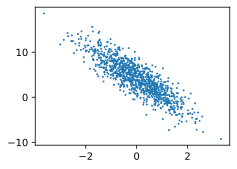

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1);

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        
        yield features[batch_indices],labels[batch_indices]
batch_size= 10
for X, y in data_iter(batch_size,features, labels):
    print(X,'\n', y)
    break

tensor([[ 1.3497, -1.2587],
        [ 0.4934, -2.2773],
        [ 0.3780,  0.6626],
        [-1.2534, -1.4652],
        [-1.7488, -0.5005],
        [ 2.6879, -1.4657],
        [ 0.1721, -0.2890],
        [-1.6151, -0.2006],
        [-1.1778, -1.6043],
        [-0.1716, -1.1671]]) 
 tensor([[11.1781],
        [12.9233],
        [ 2.6980],
        [ 6.6738],
        [ 2.4018],
        [14.5654],
        [ 5.5196],
        [ 1.6571],
        [ 7.2916],
        [ 7.8161]])


In [23]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b


In [24]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


### 除以 batch_size：

当我们在一个小批量上计算损失的梯度时，得到的是小批量的总梯度。如果不除以 batch_size，梯度更新就会变得与批量大小成正比。除以 batch_size 可以确保无论批量大小如何变化，梯度更新的幅度保持一致，避免批量大小对梯度的影响过大。
具体来说，param.grad 是小批量损失对该参数的梯度的总和（所有 batch_size 样本的梯度求和），而除以 batch_size 则是将这个总梯度平均到每个样本上，使得每个样本的贡献对梯度更新的影响相等。
保持梯度规模的一致性：

如果不除以 batch_size，随着 batch_size 的增大，梯度的绝对值也会增大，这会导致每次更新的步长过大，使得模型更新不稳定。通过除以 batch_size，我们确保了每个小批量的更新步长与批量大小无关，避免了这种问题。

### with torch.no_grad(): 
是 PyTorch 中的一种上下文管理器，用于 禁用梯度计算。在该上下文中，所有的张量操作都不会记录计算图中的梯度信息，从而节省内存和计算资源。具体来说，torch.no_grad() 会关闭自动求导机制，这对于某些操作（如推理阶段或计算验证损失）非常有用，因为在这些情况下不需要进行梯度计算。



In [25]:
for X, y in data_iter(batch_size, features, labels):
        l = squared_loss(linreg(X, w, b), y)  # 'X' 和 'y' 的小批量损失
        print(l)
        break

tensor([[ 0.8217],
        [ 4.3030],
        [28.5589],
        [25.8003],
        [56.7927],
        [ 5.3306],
        [ 7.1143],
        [10.2261],
        [31.7727],
        [ 5.8095]], grad_fn=<DivBackward0>)


In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 'X' 和 'y' 的小批量损失
        # 因为 l 形状是 (batch_size, 1)，而不是一个标量。`l` 中的所有元素被加到
        l.sum().backward()  # 并以此计算关于 `w`, `b` 的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新模型

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):.4f}')


epoch 1, loss 0.0001
epoch 2, loss 0.0001
epoch 3, loss 0.0001


In [2]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)


In [4]:
features, labels

(tensor([[ 0.5027, -0.0767],
         [-1.0390, -0.1738],
         [-0.8338, -0.1168],
         ...,
         [ 1.0802, -0.8372],
         [-0.4898,  0.8456],
         [ 0.1601, -1.0116]]),
 tensor([[ 5.4683e+00],
         [ 2.7155e+00],
         [ 2.9236e+00],
         [ 5.3942e+00],
         [ 2.8952e+00],
         [ 8.9316e+00],
         [ 3.3274e+00],
         [ 3.4396e+00],
         [ 5.3461e+00],
         [ 3.7714e+00],
         [ 4.3001e+00],
         [ 6.3471e+00],
         [-5.6679e-02],
         [ 3.9744e+00],
         [ 5.6493e+00],
         [ 9.5101e+00],
         [ 4.5542e+00],
         [ 5.3276e+00],
         [ 1.4552e+00],
         [ 1.0297e+01],
         [ 8.9532e+00],
         [ 7.7415e+00],
         [ 6.4670e+00],
         [ 6.1372e+00],
         [ 2.7906e+00],
         [ 4.7208e-01],
         [ 8.1075e+00],
         [ 5.2254e+00],
         [-4.4266e+00],
         [ 7.5352e+00],
         [ 3.5006e+00],
         [ 8.5512e+00],
         [-4.5678e-01],
         [ 2.8747e

In [3]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))


[tensor([[-5.1079e-02,  6.0140e-01],
         [ 7.3768e-01,  1.7341e-02],
         [-1.3663e+00,  2.3113e+00],
         [ 9.1258e-01,  1.0739e-01],
         [ 6.6657e-04,  1.4808e+00],
         [-6.3580e-02,  8.4832e-01],
         [-2.2256e-01,  5.3177e-01],
         [-2.3850e-01, -2.6182e-02],
         [ 3.1714e-01,  3.7765e-02],
         [-1.0420e+00,  1.5144e+00]]),
 tensor([[ 2.0587],
         [ 5.6033],
         [-6.3779],
         [ 5.6677],
         [-0.8324],
         [ 1.1751],
         [ 1.9547],
         [ 3.8060],
         [ 4.7057],
         [-3.0370]])]

在 load_array(data_arrays, batch_size, is_train=True) 中，*data_arrays 的作用是将 data_arrays 中的元素解包（unpack）成单独的参数。

具体来说：

data_arrays 是一个包含多个数组（通常是特征数据和标签数据）的元组或列表，例如 (X, y)。
*data_arrays 会将这个元组拆开，传递给 TensorDataset 函数作为独立的参数，而不是作为一个整体的元组。

data_arrays: 这是一个元组（或列表），其中包含数据特征和标签，比如 (features, labels)。这里的 features 是输入数据，labels 是目标数据。这个元组作为参数传递给 load_array 函数。

*data_arrays: 这个操作将元组解包成两个独立的参数，在这个例子中是 features 和 labels，然后传递给 TensorDataset。TensorDataset 用于将这些数据组合成一个数据集对象，使得每一个数据点（特征、标签）可以一起迭代。

data.TensorDataset(*data_arrays): TensorDataset 会将 features 和 labels 作为输入，返回一个数据集。每个数据点是由特征和标签组成的一个样本。

data.DataLoader(dataset, batch_size, shuffle=is_train): 这里 DataLoader 用于构建一个数据加载器，它负责将数据集（dataset）分成一个个小批次，并返回一个迭代器。batch_size 定义了每个批次包含多少个样本，shuffle=is_train 控制是否在每个epoch前打乱数据（通常训练时需要打乱，测试时则不需要）。

In [9]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
# w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# b = torch.zeros(1, requires_grad=True)


tensor([0.])

这段代码定义了一个简单的神经网络，并对网络的权重和偏置进行了初始化。下面是详细的解释：

### 1. **导入必要模块**
```python
from torch import nn
```
- `nn` 是 PyTorch 中神经网络模块的别名。它提供了构建神经网络所需的各种工具和层。

### 2. **构建神经网络**
```python
net = nn.Sequential(nn.Linear(2, 1))
```
- `nn.Sequential` 是一个容器类，用于将多个神经网络层按顺序组成一个网络。在这里，网络只有一个层，即 `nn.Linear(2, 1)`。
- `nn.Linear(2, 1)` 表示一个全连接层（线性层），它将 2 个输入特征映射到 1 个输出特征。具体来说，它有 2 个输入神经元和 1 个输出神经元，并且在内部有一组权重和一个偏置。

### 3. **初始化权重**
```python
net[0].weight.data.normal(0, 0.01)
```
- `net[0]` 是网络中的第一个（也是唯一的）层，`nn.Linear(2, 1)`。
- `.weight` 是该层的权重矩阵，形状为 `(1, 2)`，因为有 1 个输出神经元和 2 个输入神经元。
- `.data` 获取权重的实际数据。
- `.normal(0, 0.01)` 使用正态分布（均值为 0，标准差为 0.01）对权重进行初始化，这种初始化方式有助于避免梯度消失或爆炸问题。

### 4. **初始化偏置**
```python
net[0].bias.data.fill(0)
```
- `net[0]` 依旧是神经网络中的第一个线性层。
- `.bias` 是该层的偏置项，形状为 `(1,)`，对应着该层的输出神经元。
- `.data` 获取偏置项的实际数据。
- `.fill(0)` 将偏置项初始化为 0。

### 总结：
- 这段代码创建了一个只有一个线性层的简单神经网络。
- 该层的输入有 2 个特征，输出有 1 个特征。
- 对于该层，权重初始化为均值为 0，标准差为 0.01 的正态分布，偏置初始化为 0。

这种初始化方法有助于提高模型训练的稳定性。

In [10]:
loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [11]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000152
epoch 2, loss 0.000096
epoch 3, loss 0.000095
